In [2]:
from config import EPISODE_LEN
from env_utils import get_4wt_symmetric_env
from stable_baselines3 import PPO
import numpy as np
import tqdm

evaluations = 100

2024-10-16 01:58:31.909788: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-16 01:58:31.913080: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-16 01:58:32.004319: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-16 01:58:33.587247: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Evaluate PPO models

In [11]:
def evaluate_model(model, env, evaluations):
    total_rewards = np.zeros((evaluations, EPISODE_LEN))
    total_powers = np.zeros((evaluations, EPISODE_LEN))
    obs, info = env.reset()
    print(len(obs))
    print(info)
    for i in tqdm.tqdm(range(evaluations)):
        for j in range(EPISODE_LEN):
            action, _states = model.predict(obs)
            obs, reward, terminated, truncated, info = env.step(action)
            total_rewards[i, j] = reward
            total_powers[i, j] = info["power_output"]
            if terminated or truncated:
                break
        env.reset()
    return total_rewards, total_powers

models = [
    ("PPO unpriv", PPO.load("ppo_4wt_symmetric_unprivileged_cw_t1000000.0"), None),
    ("PPO priv 75", PPO.load("ppo_4wt_symmetric_privileged_md75_cw_t1000000.0_t1000000.0"), 75)
]
for model_name, model, mast_distancing in models:
    privileged = mast_distancing is not None
    env = get_4wt_symmetric_env(
        episode_length=EPISODE_LEN, 
        privileged=privileged, 
        mast_distancing=mast_distancing,
        changing_wind=True,
    )
    rewards, powers = evaluate_model(model, env, evaluations)
    np.save(f"data/{model_name}_rewards.npy", rewards)
    np.save(f"data/{model_name}_powers.npy", powers)

Run count: 1
Wind speed: 1.3709907296262323
Wind direction: 285
4
None


  1%|          | 1/100 [00:03<05:14,  3.18s/it]

Run count: 2
Wind speed: 5.434266187116561
Wind direction: 207


  2%|▏         | 2/100 [00:06<05:27,  3.34s/it]

Run count: 3
Wind speed: 7.685352502128577
Wind direction: 344


/home/maranc/miniconda3/envs/windfarm/lib/python3.8/site-packages/floris/simulation/wake_deflection/gauss.py:209: RuntimeWarning: invalid value encountered in sqrt
  ln_deltaNum = (1.6 + np.sqrt(M0)) * (
/home/maranc/miniconda3/envs/windfarm/lib/python3.8/site-packages/floris/simulation/wake_deflection/gauss.py:210: RuntimeWarning: invalid value encountered in sqrt
  1.6 * np.sqrt(sigma_y * sigma_z / (sigma_y0 * sigma_z0)) - np.sqrt(M0)
/home/maranc/miniconda3/envs/windfarm/lib/python3.8/site-packages/floris/simulation/wake_deflection/gauss.py:212: RuntimeWarning: invalid value encountered in sqrt
  ln_deltaDen = (1.6 - np.sqrt(M0)) * (
/home/maranc/miniconda3/envs/windfarm/lib/python3.8/site-packages/floris/simulation/wake_deflection/gauss.py:213: RuntimeWarning: invalid value encountered in sqrt
  1.6 * np.sqrt(sigma_y * sigma_z / (sigma_y0 * sigma_z0)) + np.sqrt(M0)
/home/maranc/miniconda3/envs/windfarm/lib/python3.8/site-packages/floris/simulation/wake_velocity/gaussianModels/gauss

Run count: 4
Wind speed: 14.685582381943165
Wind direction: 269


  4%|▍         | 4/100 [00:13<05:28,  3.42s/it]

Run count: 5
Wind speed: 21.47473132533486
Wind direction: 237


  5%|▌         | 5/100 [00:17<05:30,  3.48s/it]

Run count: 6
Wind speed: 23.339164242810693
Wind direction: 287


  6%|▌         | 6/100 [00:20<05:27,  3.49s/it]

Run count: 7
Wind speed: 17.311329666489193
Wind direction: 31


/home/maranc/miniconda3/envs/windfarm/lib/python3.8/site-packages/floris/simulation/wake_deflection/gauss.py:210: RuntimeWarning: invalid value encountered in divide
  1.6 * np.sqrt(sigma_y * sigma_z / (sigma_y0 * sigma_z0)) - np.sqrt(M0)
/home/maranc/miniconda3/envs/windfarm/lib/python3.8/site-packages/floris/simulation/wake_deflection/gauss.py:213: RuntimeWarning: invalid value encountered in divide
  1.6 * np.sqrt(sigma_y * sigma_z / (sigma_y0 * sigma_z0)) + np.sqrt(M0)
/home/maranc/miniconda3/envs/windfarm/lib/python3.8/site-packages/floris/simulation/wake_deflection/gauss.py:218: RuntimeWarning: invalid value encountered in multiply
  + (theta_c0 * E0 / 5.2)
/home/maranc/miniconda3/envs/windfarm/lib/python3.8/site-packages/floris/simulation/wake_velocity/gaussianModels/gauss_legacy.py:173: RuntimeWarning: divide by zero encountered in divide
  sigma_y = (((x0 - xR) - (x_locations - xR)) / (x0 - xR)) * 0.501 * D * np.sqrt(
/home/maranc/miniconda3/envs/windfarm/lib/python3.8/site-pa

Run count: 8
Wind speed: 14.56262462322271
Wind direction: 136


  8%|▊         | 8/100 [00:27<05:21,  3.49s/it]

Run count: 9
Wind speed: 21.727946671350825
Wind direction: 87


  9%|▉         | 9/100 [00:31<05:19,  3.51s/it]

Run count: 10
Wind speed: 18.445343161677837
Wind direction: 59


 10%|█         | 10/100 [00:34<05:15,  3.50s/it]

Run count: 11
Wind speed: 18.99558949894107
Wind direction: 281


 11%|█         | 11/100 [00:38<05:10,  3.49s/it]

Run count: 12
Wind speed: 19.476332698736478
Wind direction: 9


/home/maranc/miniconda3/envs/windfarm/lib/python3.8/site-packages/floris/simulation/wake_velocity/gaussianModels/gauss_legacy.py:173: RuntimeWarning: invalid value encountered in add
  sigma_y = (((x0 - xR) - (x_locations - xR)) / (x0 - xR)) * 0.501 * D * np.sqrt(
/home/maranc/miniconda3/envs/windfarm/lib/python3.8/site-packages/floris/simulation/wake_velocity/gaussianModels/gauss_legacy.py:176: RuntimeWarning: invalid value encountered in add
  sigma_z = (((x0 - xR) - (x_locations - xR)) / (x0 - xR)) * 0.501 * D * np.sqrt(
 12%|█▏        | 12/100 [00:41<05:05,  3.47s/it]

Run count: 13
Wind speed: 3.2939007577399044
Wind direction: 33


 13%|█▎        | 13/100 [00:44<04:58,  3.43s/it]

Run count: 14
Wind speed: 11.71855055294479
Wind direction: 41


 14%|█▍        | 14/100 [00:48<04:53,  3.41s/it]

Run count: 15
Wind speed: 8.925168277077727
Wind direction: 133


 15%|█▌        | 15/100 [00:51<04:41,  3.31s/it]

Run count: 16
Wind speed: 18.325535468904512
Wind direction: 326


 16%|█▌        | 16/100 [00:54<04:41,  3.35s/it]

Run count: 17
Wind speed: 14.422525790346189
Wind direction: 235


 17%|█▋        | 17/100 [00:58<04:47,  3.47s/it]

Run count: 18
Wind speed: 14.089701420071
Wind direction: 8


 18%|█▊        | 18/100 [01:02<04:47,  3.51s/it]

Run count: 19
Wind speed: 4.156874168672795
Wind direction: 135


 19%|█▉        | 19/100 [01:05<04:41,  3.48s/it]

Run count: 20
Wind speed: 9.80481213763254
Wind direction: 210


 20%|██        | 20/100 [01:09<04:39,  3.50s/it]

Run count: 21
Wind speed: 6.0784736446997805
Wind direction: 321


 21%|██        | 21/100 [01:12<04:35,  3.48s/it]

Run count: 22
Wind speed: 2.1747629642176256
Wind direction: 281


 22%|██▏       | 22/100 [01:16<04:35,  3.53s/it]

Run count: 23
Wind speed: 8.241382755456753
Wind direction: 134


 23%|██▎       | 23/100 [01:19<04:30,  3.52s/it]

Run count: 24
Wind speed: 7.607382435029586
Wind direction: 54


 24%|██▍       | 24/100 [01:23<04:25,  3.49s/it]

Run count: 25
Wind speed: 21.317966560397515
Wind direction: 47


 25%|██▌       | 25/100 [01:26<04:18,  3.45s/it]

Run count: 26
Wind speed: 0.5738668015565376
Wind direction: 299


 26%|██▌       | 26/100 [01:29<04:06,  3.33s/it]

Run count: 27
Wind speed: 10.045419244032196
Wind direction: 356


 27%|██▋       | 27/100 [01:32<04:05,  3.37s/it]

Run count: 28
Wind speed: 16.203549304952247
Wind direction: 342


 28%|██▊       | 28/100 [01:36<04:02,  3.37s/it]

Run count: 29
Wind speed: 22.444594414585655
Wind direction: 73


 29%|██▉       | 29/100 [01:39<03:56,  3.33s/it]

Run count: 30
Wind speed: 5.4974839152667405
Wind direction: 180


 30%|███       | 30/100 [01:42<03:55,  3.36s/it]

Run count: 31
Wind speed: 4.748148281721283
Wind direction: 131


 31%|███       | 31/100 [01:46<03:52,  3.37s/it]

Run count: 32
Wind speed: 3.4990460540184603
Wind direction: 234


 32%|███▏      | 32/100 [01:49<03:51,  3.40s/it]

Run count: 33
Wind speed: 24.63119756138382
Wind direction: 139


 33%|███▎      | 33/100 [01:53<03:52,  3.47s/it]

Run count: 34
Wind speed: 17.65430933874018
Wind direction: 110


 34%|███▍      | 34/100 [01:56<03:48,  3.46s/it]

Run count: 35
Wind speed: 22.480942228855127
Wind direction: 109


 35%|███▌      | 35/100 [02:00<03:44,  3.45s/it]

Run count: 36
Wind speed: 6.830417572696966
Wind direction: 347


 36%|███▌      | 36/100 [02:03<03:43,  3.50s/it]

Run count: 37
Wind speed: 24.59418407036202
Wind direction: 152


 37%|███▋      | 37/100 [02:07<03:41,  3.52s/it]

Run count: 38
Wind speed: 17.393152730555315
Wind direction: 324


 38%|███▊      | 38/100 [02:11<03:37,  3.51s/it]

Run count: 39
Wind speed: 5.139118563217217
Wind direction: 35


 39%|███▉      | 39/100 [02:14<03:36,  3.54s/it]

Run count: 40
Wind speed: 4.518194306078255
Wind direction: 185


 40%|████      | 40/100 [02:17<03:27,  3.46s/it]

Run count: 41
Wind speed: 23.33920527352235
Wind direction: 75


 41%|████      | 41/100 [02:21<03:26,  3.50s/it]

Run count: 42
Wind speed: 21.000944724323972
Wind direction: 77


 42%|████▏     | 42/100 [02:25<03:26,  3.57s/it]

Run count: 43
Wind speed: 15.777534131096548
Wind direction: 77


 43%|████▎     | 43/100 [02:28<03:21,  3.54s/it]

Run count: 44
Wind speed: 8.72265277207926
Wind direction: 174


 44%|████▍     | 44/100 [02:32<03:16,  3.51s/it]

Run count: 45
Wind speed: 0.5390971405108419
Wind direction: 85


 45%|████▌     | 45/100 [02:35<03:09,  3.44s/it]

Run count: 46
Wind speed: 0.7146843218835375
Wind direction: 172


 46%|████▌     | 46/100 [02:38<03:02,  3.38s/it]

Run count: 47
Wind speed: 0.0
Wind direction: 32


 47%|████▋     | 47/100 [02:41<02:58,  3.37s/it]

Run count: 48
Wind speed: 15.158848097843354
Wind direction: 179


 48%|████▊     | 48/100 [02:45<02:52,  3.32s/it]

Run count: 49
Wind speed: 10.70181539195511
Wind direction: 16


 49%|████▉     | 49/100 [02:48<02:49,  3.32s/it]

Run count: 50
Wind speed: 1.7076696652444925
Wind direction: 138


 50%|█████     | 50/100 [02:51<02:45,  3.31s/it]

Run count: 51
Wind speed: 21.882170154361795
Wind direction: 345


 51%|█████     | 51/100 [02:55<02:46,  3.40s/it]

Run count: 52
Wind speed: 13.850603546540228
Wind direction: 71


 52%|█████▏    | 52/100 [02:58<02:44,  3.42s/it]

Run count: 53
Wind speed: 17.861641795959226
Wind direction: 351


 53%|█████▎    | 53/100 [03:02<02:40,  3.42s/it]

Run count: 54
Wind speed: 8.748579401719299
Wind direction: 169


 54%|█████▍    | 54/100 [03:05<02:34,  3.37s/it]

Run count: 55
Wind speed: 24.388580179465308
Wind direction: 317


 55%|█████▌    | 55/100 [03:08<02:30,  3.35s/it]

Run count: 56
Wind speed: 10.586674479602792
Wind direction: 227


 56%|█████▌    | 56/100 [03:12<02:27,  3.34s/it]

Run count: 57
Wind speed: 22.391030070782634
Wind direction: 114


 57%|█████▋    | 57/100 [03:15<02:24,  3.35s/it]

Run count: 58
Wind speed: 21.015545154629976
Wind direction: 106


 58%|█████▊    | 58/100 [03:19<02:26,  3.50s/it]

Run count: 59
Wind speed: 22.071520653445518
Wind direction: 165


 59%|█████▉    | 59/100 [03:22<02:22,  3.47s/it]

Run count: 60
Wind speed: 6.874348251118982
Wind direction: 126


 60%|██████    | 60/100 [03:26<02:16,  3.41s/it]

Run count: 61
Wind speed: 15.97220891052541
Wind direction: 49


 61%|██████    | 61/100 [03:29<02:14,  3.44s/it]

Run count: 62
Wind speed: 6.907913369932869
Wind direction: 343


 62%|██████▏   | 62/100 [03:32<02:09,  3.42s/it]

Run count: 63
Wind speed: 9.672720031263092
Wind direction: 15


 63%|██████▎   | 63/100 [03:36<02:05,  3.39s/it]

Run count: 64
Wind speed: 4.448700974595384
Wind direction: 288


 64%|██████▍   | 64/100 [03:39<02:00,  3.34s/it]

Run count: 65
Wind speed: 5.353987281143036
Wind direction: 204


 65%|██████▌   | 65/100 [03:42<01:57,  3.35s/it]

Run count: 66
Wind speed: 23.34932085380242
Wind direction: 130


 66%|██████▌   | 66/100 [03:46<01:55,  3.40s/it]

Run count: 67
Wind speed: 8.357488701407092
Wind direction: 299


 67%|██████▋   | 67/100 [03:49<01:51,  3.36s/it]

Run count: 68
Wind speed: 25.0
Wind direction: 107


 68%|██████▊   | 68/100 [03:53<01:48,  3.38s/it]

Run count: 69
Wind speed: 22.075035216402433
Wind direction: 83


 69%|██████▉   | 69/100 [03:56<01:46,  3.44s/it]

Run count: 70
Wind speed: 4.4437646525450205
Wind direction: 42


 70%|███████   | 70/100 [04:00<01:42,  3.41s/it]

Run count: 71
Wind speed: 19.01761837945398
Wind direction: 324


 71%|███████   | 71/100 [04:03<01:40,  3.45s/it]

Run count: 72
Wind speed: 17.287621892260944
Wind direction: 328


 72%|███████▏  | 72/100 [04:07<01:37,  3.47s/it]

Run count: 73
Wind speed: 0.8274509220766011
Wind direction: 13


 73%|███████▎  | 73/100 [04:10<01:32,  3.44s/it]

Run count: 74
Wind speed: 12.412037607763613
Wind direction: 201


 74%|███████▍  | 74/100 [04:14<01:30,  3.49s/it]

Run count: 75
Wind speed: 23.670597656493534
Wind direction: 173


 75%|███████▌  | 75/100 [04:17<01:27,  3.49s/it]

Run count: 76
Wind speed: 20.6172894394401
Wind direction: 37


 76%|███████▌  | 76/100 [04:21<01:24,  3.53s/it]

Run count: 77
Wind speed: 3.1746550225258767
Wind direction: 279


 77%|███████▋  | 77/100 [04:24<01:19,  3.44s/it]

Run count: 78
Wind speed: 8.93556094389733
Wind direction: 163


 78%|███████▊  | 78/100 [04:28<01:17,  3.50s/it]

Run count: 79
Wind speed: 21.792937261360553
Wind direction: 143


 79%|███████▉  | 79/100 [04:31<01:13,  3.49s/it]

Run count: 80
Wind speed: 23.518009478566672
Wind direction: 86


 80%|████████  | 80/100 [04:35<01:10,  3.52s/it]

Run count: 81
Wind speed: 10.496292182256092
Wind direction: 47


 81%|████████  | 81/100 [04:38<01:06,  3.51s/it]

Run count: 82
Wind speed: 21.68216396655769
Wind direction: 246


 82%|████████▏ | 82/100 [04:41<01:01,  3.44s/it]

Run count: 83
Wind speed: 16.899660161782776
Wind direction: 139


 83%|████████▎ | 83/100 [04:45<00:58,  3.44s/it]

Run count: 84
Wind speed: 15.727788073450341
Wind direction: 301


 84%|████████▍ | 84/100 [04:48<00:54,  3.43s/it]

Run count: 85
Wind speed: 21.048136429564682
Wind direction: 48


 85%|████████▌ | 85/100 [04:52<00:51,  3.45s/it]

Run count: 86
Wind speed: 1.8127569532895496
Wind direction: 343


 86%|████████▌ | 86/100 [04:55<00:47,  3.37s/it]

Run count: 87
Wind speed: 18.917919951560574
Wind direction: 15


 87%|████████▋ | 87/100 [04:58<00:44,  3.40s/it]

Run count: 88
Wind speed: 11.696396307802722
Wind direction: 132


 88%|████████▊ | 88/100 [05:02<00:40,  3.41s/it]

Run count: 89
Wind speed: 9.426771164795815
Wind direction: 12


 89%|████████▉ | 89/100 [05:05<00:37,  3.44s/it]

Run count: 90
Wind speed: 20.009533659988946
Wind direction: 351


 90%|█████████ | 90/100 [05:09<00:34,  3.45s/it]

Run count: 91
Wind speed: 25.0
Wind direction: 93


 91%|█████████ | 91/100 [05:12<00:30,  3.44s/it]

Run count: 92
Wind speed: 14.091894398823362
Wind direction: 20


 92%|█████████▏| 92/100 [05:16<00:27,  3.45s/it]

Run count: 93
Wind speed: 19.823554934296077
Wind direction: 90


 93%|█████████▎| 93/100 [05:19<00:24,  3.45s/it]

Run count: 94
Wind speed: 0.0
Wind direction: 64


 94%|█████████▍| 94/100 [05:22<00:20,  3.36s/it]

Run count: 95
Wind speed: 0.2733812224278743
Wind direction: 306


 95%|█████████▌| 95/100 [05:26<00:16,  3.36s/it]

Run count: 96
Wind speed: 4.31827799673953
Wind direction: 301


 96%|█████████▌| 96/100 [05:29<00:13,  3.31s/it]

Run count: 97
Wind speed: 4.2561159144756315
Wind direction: 227


 97%|█████████▋| 97/100 [05:32<00:09,  3.32s/it]

Run count: 98
Wind speed: 13.906396335720332
Wind direction: 160


 98%|█████████▊| 98/100 [05:36<00:06,  3.42s/it]

Run count: 99
Wind speed: 20.265628414203256
Wind direction: 239


 99%|█████████▉| 99/100 [05:39<00:03,  3.44s/it]

Run count: 100
Wind speed: 1.6330620108203897
Wind direction: 170


100%|██████████| 100/100 [05:43<00:00,  3.43s/it]


Run count: 101
Wind speed: 23.523464537450906
Wind direction: 107
Making env with n masts: 9
Run count: 1
Wind speed: 22.106816229890814
Wind direction: 347
22
None


  1%|          | 1/100 [00:07<12:52,  7.81s/it]

Run count: 2
Wind speed: 23.680326426852666
Wind direction: 64


  2%|▏         | 2/100 [00:15<12:33,  7.69s/it]

Run count: 3
Wind speed: 1.8067570026995736
Wind direction: 306


  3%|▎         | 3/100 [00:22<12:00,  7.43s/it]

Run count: 4
Wind speed: 8.194782608767705
Wind direction: 336


  4%|▍         | 4/100 [00:30<11:57,  7.47s/it]

Run count: 5
Wind speed: 18.20648890042726
Wind direction: 5


  5%|▌         | 5/100 [00:37<12:00,  7.59s/it]

Run count: 6
Wind speed: 19.66848228981513
Wind direction: 39


  6%|▌         | 6/100 [00:45<11:53,  7.59s/it]

Run count: 7
Wind speed: 22.672519647866412
Wind direction: 46


  7%|▋         | 7/100 [00:53<11:47,  7.61s/it]

Run count: 8
Wind speed: 14.064189316795044
Wind direction: 162


  8%|▊         | 8/100 [01:00<11:36,  7.57s/it]

Run count: 9
Wind speed: 0.0
Wind direction: 57


  9%|▉         | 9/100 [01:07<11:20,  7.48s/it]

Run count: 10
Wind speed: 14.983638866520472
Wind direction: 353


 10%|█         | 10/100 [01:15<11:16,  7.51s/it]

Run count: 11
Wind speed: 7.875496594489231
Wind direction: 259


 11%|█         | 11/100 [01:23<11:14,  7.58s/it]

Run count: 12
Wind speed: 14.349890204158214
Wind direction: 51


 12%|█▏        | 12/100 [01:30<11:04,  7.55s/it]

Run count: 13
Wind speed: 21.38268396273745
Wind direction: 14


 13%|█▎        | 13/100 [01:38<11:01,  7.61s/it]

Run count: 14
Wind speed: 17.72291147748924
Wind direction: 328


 14%|█▍        | 14/100 [01:45<10:52,  7.58s/it]

Run count: 15
Wind speed: 10.573121458222573
Wind direction: 263


 15%|█▌        | 15/100 [01:53<10:42,  7.56s/it]

Run count: 16
Wind speed: 17.049139403915376
Wind direction: 107


 16%|█▌        | 16/100 [02:00<10:33,  7.54s/it]

Run count: 17
Wind speed: 20.625763750013014
Wind direction: 294


 17%|█▋        | 17/100 [02:08<10:18,  7.46s/it]

Run count: 18
Wind speed: 0.24880624673161056
Wind direction: 156


 18%|█▊        | 18/100 [02:15<10:11,  7.45s/it]

Run count: 19
Wind speed: 2.906355776956262
Wind direction: 151


 19%|█▉        | 19/100 [02:23<10:05,  7.47s/it]

Run count: 20
Wind speed: 10.095355607813428
Wind direction: 136


 20%|██        | 20/100 [02:30<10:00,  7.51s/it]

Run count: 21
Wind speed: 21.46277111559362
Wind direction: 49


 21%|██        | 21/100 [02:38<10:00,  7.60s/it]

Run count: 22
Wind speed: 9.263482292987657
Wind direction: 320


 22%|██▏       | 22/100 [02:46<09:59,  7.68s/it]

Run count: 23
Wind speed: 10.76631511541029
Wind direction: 66


 23%|██▎       | 23/100 [02:54<09:55,  7.73s/it]

Run count: 24
Wind speed: 10.416774584453535
Wind direction: 47


 24%|██▍       | 24/100 [03:01<09:46,  7.72s/it]

Run count: 25
Wind speed: 5.1597178000011725
Wind direction: 218


 25%|██▌       | 25/100 [03:09<09:29,  7.59s/it]

Run count: 26
Wind speed: 6.271107030450515
Wind direction: 74


 26%|██▌       | 26/100 [03:16<09:17,  7.54s/it]

Run count: 27
Wind speed: 10.302240880733793
Wind direction: 278


 27%|██▋       | 27/100 [03:24<09:12,  7.57s/it]

Run count: 28
Wind speed: 10.141801398296634
Wind direction: 240


 28%|██▊       | 28/100 [03:31<09:05,  7.58s/it]

Run count: 29
Wind speed: 19.998978093311244
Wind direction: 200


 29%|██▉       | 29/100 [03:39<08:59,  7.60s/it]

Run count: 30
Wind speed: 22.414380039727952
Wind direction: 158


 30%|███       | 30/100 [03:47<08:52,  7.61s/it]

Run count: 31
Wind speed: 0.28301768034029506
Wind direction: 101


 31%|███       | 31/100 [03:54<08:43,  7.58s/it]

Run count: 32
Wind speed: 7.708109174562442
Wind direction: 28


 32%|███▏      | 32/100 [04:02<08:32,  7.54s/it]

Run count: 33
Wind speed: 20.878237740286774
Wind direction: 352


 33%|███▎      | 33/100 [04:09<08:29,  7.60s/it]

Run count: 34
Wind speed: 11.15471172847886
Wind direction: 96


 34%|███▍      | 34/100 [04:17<08:19,  7.57s/it]

Run count: 35
Wind speed: 11.88438728566775
Wind direction: 242


 35%|███▌      | 35/100 [04:24<08:07,  7.50s/it]

Run count: 36
Wind speed: 16.316857908540065
Wind direction: 220


 36%|███▌      | 36/100 [04:32<08:01,  7.52s/it]

Run count: 37
Wind speed: 22.91405607024751
Wind direction: 250


 37%|███▋      | 37/100 [04:39<07:55,  7.54s/it]

Run count: 38
Wind speed: 4.921953415096344
Wind direction: 326


 38%|███▊      | 38/100 [04:47<07:52,  7.62s/it]

Run count: 39
Wind speed: 19.84133876830847
Wind direction: 289


 39%|███▉      | 39/100 [04:55<07:48,  7.69s/it]

Run count: 40
Wind speed: 9.488619558741561
Wind direction: 347


 40%|████      | 40/100 [05:03<07:42,  7.71s/it]

Run count: 41
Wind speed: 1.7980041545528267
Wind direction: 301


 41%|████      | 41/100 [05:11<07:40,  7.80s/it]

Run count: 42
Wind speed: 15.442564441373516
Wind direction: 5


 42%|████▏     | 42/100 [05:19<07:38,  7.90s/it]

Run count: 43
Wind speed: 19.42647220530764
Wind direction: 350


 43%|████▎     | 43/100 [05:27<07:34,  7.97s/it]

Run count: 44
Wind speed: 3.164484674862827
Wind direction: 82


 44%|████▍     | 44/100 [05:35<07:24,  7.94s/it]

Run count: 45
Wind speed: 6.274656103486101
Wind direction: 100


 45%|████▌     | 45/100 [05:43<07:16,  7.93s/it]

Run count: 46
Wind speed: 2.4086888590006934
Wind direction: 106


 46%|████▌     | 46/100 [05:51<07:11,  7.99s/it]

Run count: 47
Wind speed: 8.293943187175081
Wind direction: 205


 47%|████▋     | 47/100 [05:58<06:55,  7.84s/it]

Run count: 48
Wind speed: 22.27369441615717
Wind direction: 353


 48%|████▊     | 48/100 [06:06<06:49,  7.88s/it]

Run count: 49
Wind speed: 4.233451049908426
Wind direction: 72


 49%|████▉     | 49/100 [06:15<06:45,  7.95s/it]

Run count: 50
Wind speed: 8.502197387574371
Wind direction: 254


 50%|█████     | 50/100 [06:22<06:32,  7.85s/it]

Run count: 51
Wind speed: 25.0
Wind direction: 298


 51%|█████     | 51/100 [06:30<06:24,  7.85s/it]

Run count: 52
Wind speed: 1.964171372747189
Wind direction: 1


 52%|█████▏    | 52/100 [06:37<06:07,  7.65s/it]

Run count: 53
Wind speed: 17.34602911235747
Wind direction: 105


 53%|█████▎    | 53/100 [06:45<05:57,  7.61s/it]

Run count: 54
Wind speed: 21.004223189289597
Wind direction: 132


 54%|█████▍    | 54/100 [06:52<05:50,  7.62s/it]

Run count: 55
Wind speed: 9.770610232392347
Wind direction: 322


 55%|█████▌    | 55/100 [07:00<05:44,  7.66s/it]

Run count: 56
Wind speed: 4.910847039965545
Wind direction: 339


 56%|█████▌    | 56/100 [07:08<05:43,  7.82s/it]

Run count: 57
Wind speed: 23.974638667531707
Wind direction: 13


 57%|█████▋    | 57/100 [07:16<05:37,  7.85s/it]

Run count: 58
Wind speed: 16.336339690558326
Wind direction: 209


 58%|█████▊    | 58/100 [07:24<05:27,  7.81s/it]

Run count: 59
Wind speed: 20.710511280193895
Wind direction: 113


 59%|█████▉    | 59/100 [07:32<05:21,  7.84s/it]

Run count: 60
Wind speed: 15.414590834505713
Wind direction: 166


 60%|██████    | 60/100 [07:40<05:12,  7.82s/it]

Run count: 61
Wind speed: 3.478252819397368
Wind direction: 153


 61%|██████    | 61/100 [07:48<05:05,  7.83s/it]

Run count: 62
Wind speed: 21.707967857012058
Wind direction: 127


 62%|██████▏   | 62/100 [07:55<04:56,  7.81s/it]

Run count: 63
Wind speed: 15.746540557629597
Wind direction: 115


 63%|██████▎   | 63/100 [08:03<04:48,  7.79s/it]

Run count: 64
Wind speed: 12.293697025207805
Wind direction: 135


 64%|██████▍   | 64/100 [08:11<04:40,  7.79s/it]

Run count: 65
Wind speed: 10.905872931286291
Wind direction: 341


 65%|██████▌   | 65/100 [08:19<04:31,  7.77s/it]

Run count: 66
Wind speed: 12.071260862137422
Wind direction: 195


 66%|██████▌   | 66/100 [08:26<04:22,  7.73s/it]

Run count: 67
Wind speed: 17.18607490401331
Wind direction: 270


 67%|██████▋   | 67/100 [08:34<04:14,  7.72s/it]

Run count: 68
Wind speed: 6.317883560961378
Wind direction: 223


 68%|██████▊   | 68/100 [08:42<04:08,  7.75s/it]

Run count: 69
Wind speed: 11.985479572278015
Wind direction: 307


 69%|██████▉   | 69/100 [08:49<03:59,  7.74s/it]

Run count: 70
Wind speed: 9.493162982244861
Wind direction: 356


 70%|███████   | 70/100 [08:57<03:52,  7.75s/it]

Run count: 71
Wind speed: 9.946303667520587
Wind direction: 352


 71%|███████   | 71/100 [09:05<03:44,  7.73s/it]

Run count: 72
Wind speed: 13.6999711736938
Wind direction: 293


 72%|███████▏  | 72/100 [09:13<03:36,  7.74s/it]

Run count: 73
Wind speed: 4.081052180886347
Wind direction: 125


 73%|███████▎  | 73/100 [09:20<03:25,  7.61s/it]

Run count: 74
Wind speed: 1.501490539824415
Wind direction: 157


 74%|███████▍  | 74/100 [09:27<03:15,  7.53s/it]

Run count: 75
Wind speed: 0.3980840232714553
Wind direction: 202


 75%|███████▌  | 75/100 [09:35<03:09,  7.57s/it]

Run count: 76
Wind speed: 21.391083657905586
Wind direction: 21


 76%|███████▌  | 76/100 [09:42<03:01,  7.55s/it]

Run count: 77
Wind speed: 22.04308646219314
Wind direction: 125


 77%|███████▋  | 77/100 [09:50<02:55,  7.64s/it]

Run count: 78
Wind speed: 13.24562038528044
Wind direction: 223


 78%|███████▊  | 78/100 [09:58<02:48,  7.67s/it]

Run count: 79
Wind speed: 3.7031331808411396
Wind direction: 150


 79%|███████▉  | 79/100 [10:06<02:40,  7.62s/it]

Run count: 80
Wind speed: 6.320094272441139
Wind direction: 204


 80%|████████  | 80/100 [10:13<02:33,  7.67s/it]

Run count: 81
Wind speed: 18.47297364341393
Wind direction: 224


 81%|████████  | 81/100 [10:21<02:25,  7.68s/it]

Run count: 82
Wind speed: 22.384815716437604
Wind direction: 265


 82%|████████▏ | 82/100 [10:29<02:18,  7.68s/it]

Run count: 83
Wind speed: 18.614551848294816
Wind direction: 99


 83%|████████▎ | 83/100 [10:36<02:09,  7.63s/it]

Run count: 84
Wind speed: 10.352465065550938
Wind direction: 226


 84%|████████▍ | 84/100 [10:44<02:01,  7.60s/it]

Run count: 85
Wind speed: 5.903973523607785
Wind direction: 3


 85%|████████▌ | 85/100 [10:51<01:53,  7.60s/it]

Run count: 86
Wind speed: 24.636605100555954
Wind direction: 39


 86%|████████▌ | 86/100 [10:59<01:47,  7.65s/it]

Run count: 87
Wind speed: 14.856861420742812
Wind direction: 128


 87%|████████▋ | 87/100 [11:07<01:39,  7.64s/it]

Run count: 88
Wind speed: 2.4365983667145246
Wind direction: 3


 88%|████████▊ | 88/100 [11:15<01:32,  7.69s/it]

Run count: 89
Wind speed: 16.28830947194823
Wind direction: 44


 89%|████████▉ | 89/100 [11:22<01:24,  7.64s/it]

Run count: 90
Wind speed: 18.09723018316721
Wind direction: 215


 90%|█████████ | 90/100 [11:30<01:16,  7.66s/it]

Run count: 91
Wind speed: 21.844888834206078
Wind direction: 167


 91%|█████████ | 91/100 [11:37<01:08,  7.67s/it]

Run count: 92
Wind speed: 3.5446172212225653
Wind direction: 90


 92%|█████████▏| 92/100 [11:45<01:00,  7.60s/it]

Run count: 93
Wind speed: 16.35976036539008
Wind direction: 189


 93%|█████████▎| 93/100 [11:53<00:53,  7.60s/it]

Run count: 94
Wind speed: 25.0
Wind direction: 116


 94%|█████████▍| 94/100 [12:00<00:45,  7.63s/it]

Run count: 95
Wind speed: 15.516881826966513
Wind direction: 23


 95%|█████████▌| 95/100 [12:08<00:38,  7.66s/it]

Run count: 96
Wind speed: 12.492534420727779
Wind direction: 62


 96%|█████████▌| 96/100 [12:16<00:30,  7.68s/it]

Run count: 97
Wind speed: 2.256248885794352
Wind direction: 332


 97%|█████████▋| 97/100 [12:23<00:22,  7.66s/it]

Run count: 98
Wind speed: 9.776042717619838
Wind direction: 107


 98%|█████████▊| 98/100 [12:30<00:15,  7.52s/it]

Run count: 99
Wind speed: 12.150508826474427
Wind direction: 264


 99%|█████████▉| 99/100 [12:38<00:07,  7.49s/it]

Run count: 100
Wind speed: 19.434781538932796
Wind direction: 215


100%|██████████| 100/100 [12:46<00:00,  7.66s/it]

Run count: 101
Wind speed: 20.935528451857824
Wind direction: 343


# Evalute SR proportional controller

In [ ]:
from serial_refine_agent import SR_ProportionalController
from env_utils import get_4wt_symmetric_env

# Load agent and environment
agent = SR_ProportionalController()
env = get_4wt_symmetric_env(episode_length=EPISODE_LEN, privileged=False, changing_wind=True, action_representation="yaw")

# Evaluate agent
obs, info = env.reset()
total_rewards = np.zeros((evaluations, EPISODE_LEN))
total_powers = np.zeros((evaluations, EPISODE_LEN))
for i in tqdm.tqdm(range(evaluations)):
    for j in range(EPISODE_LEN):
        wind_direction = env.wind_process.wind_direction
        current_yaws = env.yaws_from_wind

        action = agent.predict(wind_direction, current_yaws)
        obs, reward, terminated, truncated, info = env.step(action)

        total_rewards[i, j] = reward
        total_powers[i, j] = info["power_output"]

        if terminated or truncated:
            break
    env.reset()

np.save("data/SR_proportional_rewards.npy", total_rewards)
np.save("data/SR_proportional_powers.npy", total_powers)

# Evaluate agent in noisy environment
obs, info = env.reset()
total_rewards = np.zeros((evaluations, EPISODE_LEN))
total_powers = np.zeros((evaluations, EPISODE_LEN))
for i in tqdm.tqdm(range(evaluations)):
    for j in range(EPISODE_LEN):
        wind_direction = env.wind_process.wind_direction
        current_yaws = env.yaws_from_wind

        # Add noise to wind direction
        wind_direction = wind_direction + np.random.normal(0, 5)

        action = agent.predict(wind_direction, current_yaws)
        obs, reward, terminated, truncated, info = env.step(action)

        total_rewards[i, j] = reward
        total_powers[i, j] = info["power_output"]

        if terminated or truncated:
            break
    env.reset()

np.save("data/SR_proportional_noisy_rewards.npy", total_rewards)
np.save("data/SR_proportional_noisy_powers.npy", total_powers)

  0%|          | 0/100 [00:00<?, ?it/s]

/home/maranc/miniconda3/envs/windfarm/lib/python3.8/site-packages/floris/simulation/wake_deflection/gauss.py:209: RuntimeWarning: invalid value encountered in sqrt
  ln_deltaNum = (1.6 + np.sqrt(M0)) * (
/home/maranc/miniconda3/envs/windfarm/lib/python3.8/site-packages/floris/simulation/wake_deflection/gauss.py:210: RuntimeWarning: invalid value encountered in sqrt
  1.6 * np.sqrt(sigma_y * sigma_z / (sigma_y0 * sigma_z0)) - np.sqrt(M0)
/home/maranc/miniconda3/envs/windfarm/lib/python3.8/site-packages/floris/simulation/wake_deflection/gauss.py:212: RuntimeWarning: invalid value encountered in sqrt
  ln_deltaDen = (1.6 - np.sqrt(M0)) * (
/home/maranc/miniconda3/envs/windfarm/lib/python3.8/site-packages/floris/simulation/wake_deflection/gauss.py:213: RuntimeWarning: invalid value encountered in sqrt
  1.6 * np.sqrt(sigma_y * sigma_z / (sigma_y0 * sigma_z0)) + np.sqrt(M0)
/home/maranc/miniconda3/envs/windfarm/lib/python3.8/site-packages/floris/simulation/wake_velocity/gaussianModels/gauss

# Plot comparisons

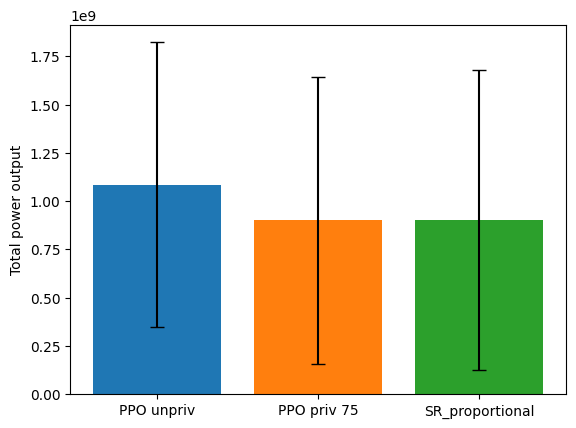

In [6]:
import matplotlib.pyplot as plt

models = ["PPO unpriv", "PPO priv 75", "SR_proportional"]#, "SR_proportional_noisy"]

# Plot power for each model as barplot
fig, ax = plt.subplots()
for model in models:
    powers = np.load(f"data/{model}_powers.npy")
    ep_powers = powers.sum(axis=1)
    ax.bar(model, ep_powers.mean(), yerr=ep_powers.std(), capsize=5)
plt.ylabel("Total power output")
plt.show()